In [1]:
# import important packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sys
sys.path.insert(0,'../scripts/')
import warnings
warnings.filterwarnings(action="ignore")

In [2]:
df = pd.read_csv("../data/AdSmartABdata.csv")
df_control= pd.read_csv("../data/control_group_data.csv")
df_exposed= pd.read_csv("../data/exposed_clean_data.csv")

In [4]:
df_control['response'].head()

0    1
1    1
2    1
3    1
4    1
Name: response, dtype: int64

In [10]:
df.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
16,008aafdf-deef-4482-8fec-d98e3da054da,exposed,2020-07-04,16,Generic Smartphone,6,Chrome Mobile,1,0
20,00a1384a-5118-4d1b-925b-6cdada50318d,exposed,2020-07-06,8,Generic Smartphone,6,Chrome Mobile,0,1
23,00b6fadb-10bd-49e3-a778-290da82f7a8d,control,2020-07-08,4,Samsung SM-A202F,6,Facebook,1,0
27,00ebf4a8-060f-4b99-93ac-c62724399483,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,1


In [5]:
# Dropping observations where there was no response to the presented questionaire
dp = df.query('yes==0 and no==0')
df = df.drop(dp.index)

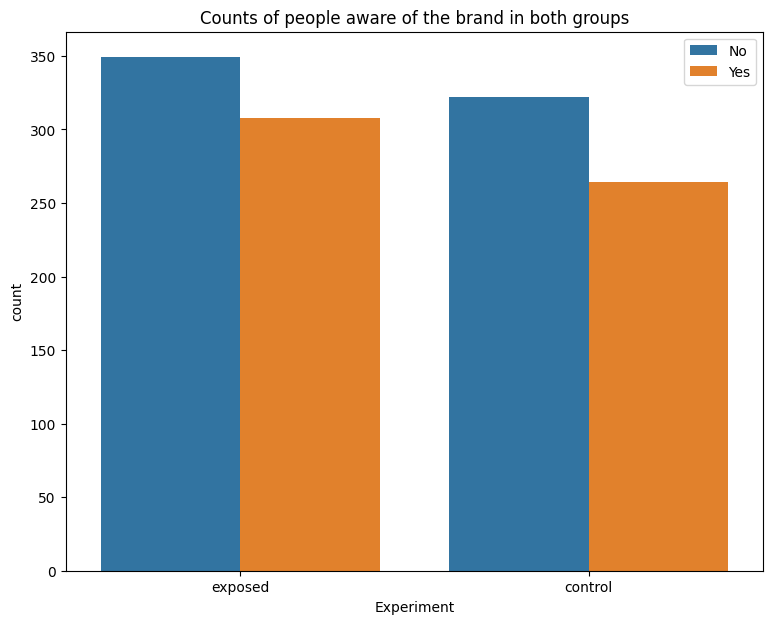

In [8]:
# Counting the people that are aware of the brand in both groups
plt.figure(figsize=(9,7))
axis = sns.countplot(x='experiment', hue='yes', data=df)
axis.set_xlabel('Experiment')
axis.set_ylabel('count')
axis.set_title('Counts of people aware of the brand in both groups')
plt.legend(['No', 'Yes'])


Text(0.5, 1.0, 'Count of Browsers used by the participants')

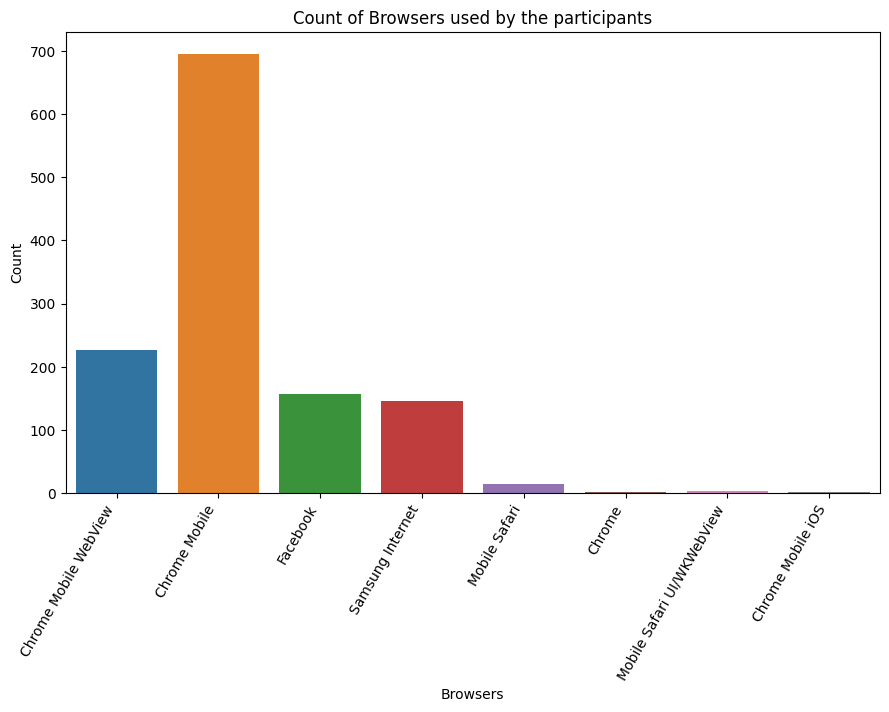

In [9]:
# Count plot of browsrs
plt.figure(figsize=(9,7))
axis = sns.countplot(x='browser', data=df)
axis.set_xticklabels(axis.get_xticklabels(), rotation=60, ha='right')
plt.tight_layout()
axis.set_xlabel('Browsers')
axis.set_ylabel('Count')
axis.set_title('Count of Browsers used by the participants')


Text(0.5, 1.0, 'Distribution fo Hour')

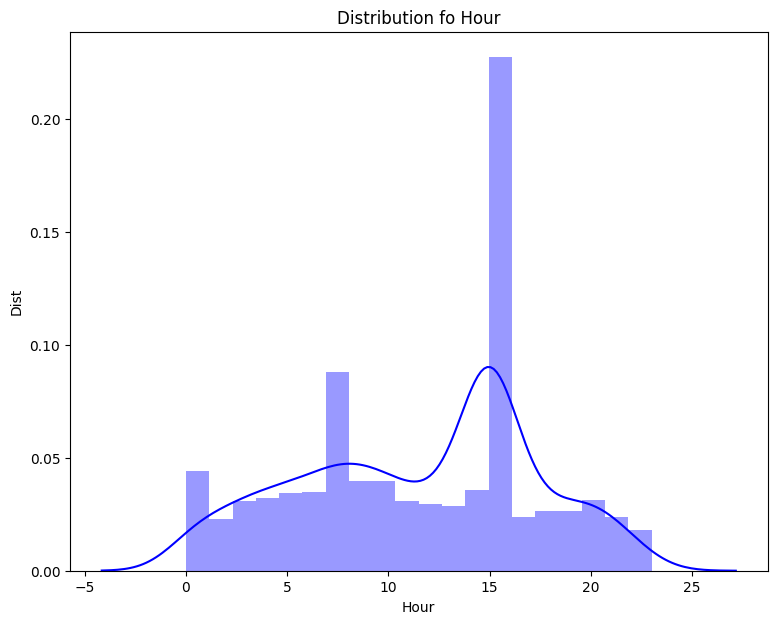

In [13]:
# Distribution of Hour
plt.figure(figsize=(9,7))
axis = sns.distplot(df['hour'],bins=20, color='blue')
axis.set_xlabel('Hour')
axis.set_ylabel('Dist')
#axis.title('Distribution fo Hour')
plt.title('Distribution fo Hour')


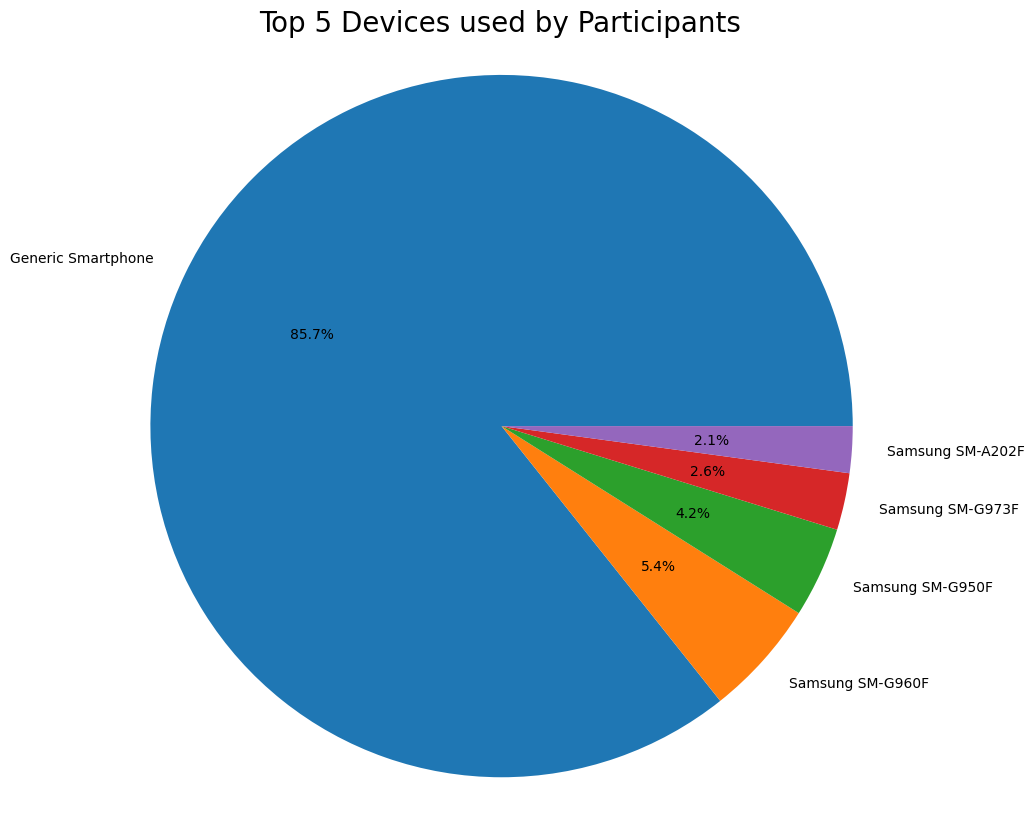

In [18]:
# Top 5 Devices
t5_device = df['device_make'].value_counts().nlargest(5)
fig1,ax1 = plt.subplots(figsize=(10,10))
ax1.pie(t5_device.values, labels=t5_device.index, autopct='%1.1f%%')
ax1.axis('equal')
ax1.set_title('Top 5 Devices used by Participants', font='bold',fontsize=20)
plt.show()

In [20]:
#df_control.shape

(586, 9)

In [21]:
#df_exposed.shape

(657, 9)

In [22]:
# the number of aware people vs the total people
exposed_yes = df.query('experiment == "exposed"').yes
exposed_count = len(exposed_yes)
exposed_yes_count = exposed_yes.sum(axis=0)

control_yes = df.query('experiment == "control"').yes
control_count = len(control_yes)
control_yes_count = control_yes.sum(axis=0)
print('Control yes count:',control_yes_count,'    Total Control:',control_count)
print('Exposed yes count:',exposed_yes_count,'    Total Exposed:',exposed_count)

Control yes count: 264     Total Control: 586
Exposed yes count: 308     Total Exposed: 657


In [25]:
#! python -m pip install statsmodels 
import statsmodels.stats.api as sms
# Determine the required sample size and check if we have sufficent sample size
#  
baseline_rate = control_yes_count / control_count
practical_significance = 0.01  # minimum required effect size
confidence_level = 0.05 
sensitivity = 0.8 

effect_size = sms.proportion_effectsize(baseline_rate, baseline_rate + practical_significance)
sample_size = sms.NormalIndPower().solve_power(effect_size = effect_size, power = sensitivity, 
                                               alpha = confidence_level, ratio=1)
print("Required sample size: ", round(sample_size), " per group")

Required sample size:  38932  per group


We can see we don't have the required sample size as we only have 586 and 657 in the total control and total exposed group respectively

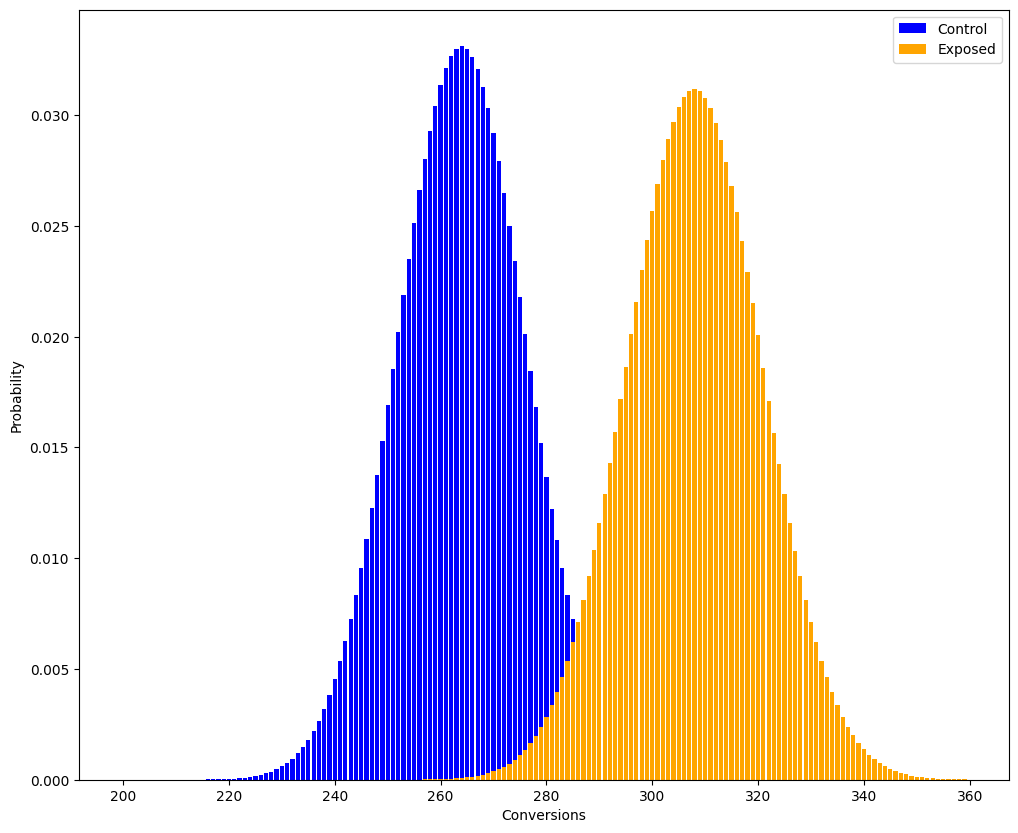

In [26]:
from scipy.stats import binom
# Calculate the Conversions for each group
cv_rate_control, cv_rate_exposed = control_yes_count / control_count, exposed_yes_count / exposed_count
range = np.arange(200, 360)
cv_prob_control = binom(control_count, cv_rate_control).pmf(range)
cv_prob_exposed = binom(exposed_count, cv_rate_exposed).pmf(range)
fig, ax = plt.subplots(figsize=(12,10))
plt.bar(range, cv_prob_control, label="Control",color='blue')
plt.bar(range, cv_prob_exposed, label="Exposed",color='orange')
plt.legend()
plt.xlabel("Conversions"); plt.ylabel("Probability");

#### This shows the exposed group has an edge in conversion. i.e the controlled group converted more then the exposed group. 
* Which still doesn't mean the experiment was a success. We can also see the peak of the Exposed group is lower than the control group. But we should focus on the conversion rate so we have an applees to apples comparison. 

### Calculate the standard deviation for each experiment group.
This will allow us to change our binomial distribution to normal distribution and calculate Z-scores

In [28]:
std_control = np.sqrt(cv_rate_control * (1 - cv_rate_control) / control_count)
std_exposed = np.sqrt(cv_rate_exposed * (1 - cv_rate_exposed) / exposed_count)

### Calculate the conversion rates for the experiment groups and plot the probabilit distribution

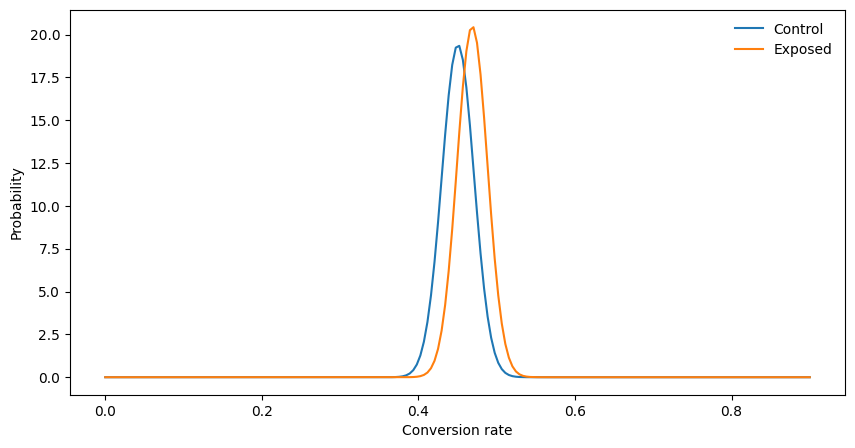

In [29]:
from scipy.stats import norm
conversion_rate = np.linspace(0, 0.9, 200)
prob_a = norm(cv_rate_control, std_control).pdf(conversion_rate)
prob_b = norm(cv_rate_exposed, std_exposed).pdf(conversion_rate)
plt.figure(figsize=(10,5))
plt.plot(conversion_rate, prob_a, label="Control")
plt.plot(conversion_rate, prob_b, label="Exposed")
plt.legend(frameon=False)
plt.xlabel("Conversion rate"); plt.ylabel("Probability");

We can also see here the exposed group has an edge! 

### Calculate the p-value and Z-score